In [1]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



![image.png](attachment:image.png)

In [ ]:
# earnings differences, men vs women
load(url('https://datasets.stats306.org/cps.RData'))

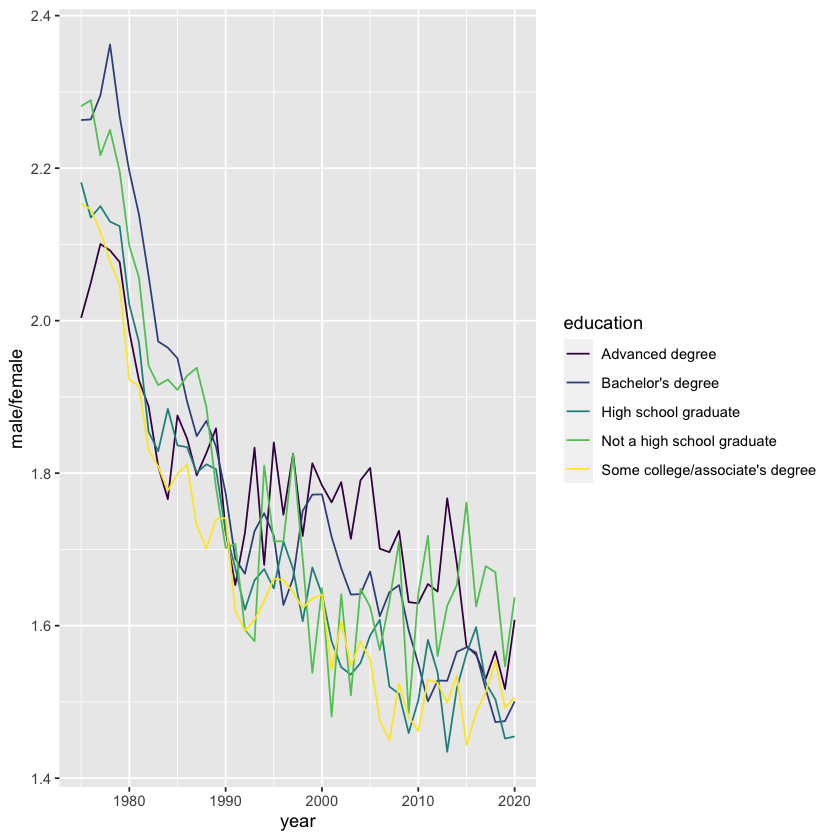

In [ ]:
# make better plot
earnings %>% select(education, year, sex, Mean) %>% pivot_wider(names_from=sex, values_from=Mean) %>% 
    ggplot(aes(x = year, y = male / female, color = education)) + geom_line()

To explore this relationship further, we naturally want to bring in other data. For example, one hypothesis is that the wage gap is diminshing in part because women are having fewer children. To study this, we want to get some data about childbearing tendencies in the U.S., and see study how it relates to the wage gap.

The U.S. census has [detailed data](https://www.census.gov/data/tables/time-series/demo/fertility/his-cps.html#par_list) on female childbearing over time.

I have gone ahead and extracted these a subset of this spreadsheet into the following data frame:

In [ ]:
pct_childless <- tibble::tribble(
  ~year, ~X25.29, ~X35.39,
   2018,    54.2,    33.6,
   2016,    53.8,    30.8,
   2014,    49.6,    28.9,
   2012,    49.4,    28.2,
   2010,    47.6,    29.7,
   2008,    46.2,    26.8,
   2006,    45.6,    26.2,
   2004,    44.2,    27.6,
   2002,    45.5,    27.7,
   2000,    44.2,    28.1,
   1998,    43.5,    27.4,
   1995,    43.8,    26.7,
   1994,    43.6,    26.3,
   1992,    41.3,    26.1,
   1990,    42.1,    25.7,
   1988,    42.2,    25.1,
   1987,    39.3,    23.6,
   1986,    40.7,    23.9,
   1985,    41.5,    26.2,
   1984,    39.9,    23.5,
   1983,    39.5,    22.9,
   1982,    38.8,    22.5,
   1981,    37.2,    20.6,
   1980,    36.8,    19.8,
   1976,    30.8,    15.6
  )

(Next week you will learn how to import data from spreadsheets on your own.)

In [ ]:
print(pct_childless)

# A tibble: 25 × 3
    year X25.29 X35.39
   <dbl>  <dbl>  <dbl>
 1  2018   54.2   33.6
 2  2016   53.8   30.8
 3  2014   49.6   28.9
 4  2012   49.4   28.2
 5  2010   47.6   29.7
 6  2008   46.2   26.8
 7  2006   45.6   26.2
 8  2004   44.2   27.6
 9  2002   45.5   27.7
10  2000   44.2   28.1
# … with 15 more rows


To compare these data, we need to somehow "match up" the data in `earnings` and `pct_childless`. An "ideal" table for studying this relationship would look like:

```
    # A tibble: 25 × 3
        year   age     wage.gap   pct.childless
       <dbl>  <fct>   <dbl>      <dbl>
     1  2018   25-29   1.451      .14
     2  2018   35-39   1.143      .10
    # … with 23 more rows
```

This lecture will teach us about "joining" data in this way.

# Lecture 09: Relational Data
<div style="border: 1px double black; padding: 10px; margin: 10px">

**Goals for today's lecture:**
* Learn about [keys](#Keys)
* Different types of [relations](#Relations) between tables
* [Commands for joining related tables together](#Outer-joins)
</div>


We have already spent a lot of time analyzing the `flights` table. In fact, there are four other tables in `nycflights13` that contain related information about these flights:

In [ ]:
print(airlines)

# A tibble: 16 x 2
   carrier name                       
   <chr>   <chr>                      
 1 9E      Endeavor Air Inc.          
 2 AA      American Airlines Inc.     
 3 AS      Alaska Airlines Inc.       
 4 B6      JetBlue Airways            
 5 DL      Delta Air Lines Inc.       
 6 EV      ExpressJet Airlines Inc.   
 7 F9      Frontier Airlines Inc.     
 8 FL      AirTran Airways Corporation
 9 HA      Hawaiian Airlines Inc.     
10 MQ      Envoy Air                  
11 OO      SkyWest Airlines Inc.      
12 UA      United Air Lines Inc.      
13 US      US Airways Inc.            
14 VX      Virgin America             
15 WN      Southwest Airlines Co.     
16 YV      Mesa Airlines Inc.         


In [ ]:
airports %>% filter(faa == "DTW")

  faa name                   lat      lon       alt tz dst tzone           
1 DTW Detroit Metro Wayne Co 42.21244 -83.35339 645 -5 A   America/New_York

In [ ]:
print(planes)

# A tibble: 3,322 x 9
   tailnum  year type          manufacturer   model  engines seats speed engine 
   <chr>   <int> <chr>         <chr>          <chr>    <int> <int> <int> <chr>  
 1 N10156   2004 Fixed wing m… EMBRAER        EMB-1…       2    55    NA Turbo-…
 2 N102UW   1998 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 3 N103US   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 4 N104UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 5 N10575   2002 Fixed wing m… EMBRAER        EMB-1…       2    55    NA Turbo-…
 6 N105UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 7 N107US   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 8 N108UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 9 N109UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
10 N110UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
# … wi

In [ ]:
print(weather)

# A tibble: 26,115 x 15
   origin  year month   day  hour  temp  dewp humid wind_dir wind_speed
   <chr>  <dbl> <dbl> <int> <int> <dbl> <dbl> <dbl>    <dbl>      <dbl>
 1 EWR     2013     1     1     1  39.0  26.1  59.4      270      10.4 
 2 EWR     2013     1     1     2  39.0  27.0  61.6      250       8.06
 3 EWR     2013     1     1     3  39.0  28.0  64.4      240      11.5 
 4 EWR     2013     1     1     4  39.9  28.0  62.2      250      12.7 
 5 EWR     2013     1     1     5  39.0  28.0  64.4      260      12.7 
 6 EWR     2013     1     1     6  37.9  28.0  67.2      240      11.5 
 7 EWR     2013     1     1     7  39.0  28.0  64.4      240      15.0 
 8 EWR     2013     1     1     8  39.9  28.0  62.2      250      10.4 
 9 EWR     2013     1     1     9  39.9  28.0  62.2      260      15.0 
10 EWR     2013     1     1    10  41    28.0  59.6      260      13.8 
# … with 26,105 more rows, and 5 more variables: wind_gust <dbl>, precip <dbl>,
#   pressure <dbl>, visib <dbl>,

Together these four tables form a *relational database*. The relationships can be graphed like so:
![table relationships](http://r4ds.had.co.nz/diagrams/relational-nycflights.png)

The particular relationships in this database are:
- `flights` connects to `planes` via `tailnum`.
- `flights` connects to `airlines` via `carrier`.
- `flights` connects to `airports` twice: via `origin` and `dest`.
- `flights` connects to `weather` via `origin` (the location), and `year`, `month`, `day` and `hour`.

## Keys
The "key" to understanding relational databases is... keys. 



### Primary Key
A *primary key* is a variable (or set of variables) that uniquely identifies an observation in its own table: there is **at most** one row in the table that corresponds to any setting of the columns which comprise the key.

In the `planes` table, each airplane is identified by its `tailnum`:

In [ ]:
print(planes)

# A tibble: 3,322 x 9
   tailnum  year type          manufacturer   model  engines seats speed engine 
   <chr>   <int> <chr>         <chr>          <chr>    <int> <int> <int> <chr>  
 1 N10156   2004 Fixed wing m… EMBRAER        EMB-1…       2    55    NA Turbo-…
 2 N102UW   1998 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 3 N103US   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 4 N104UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 5 N10575   2002 Fixed wing m… EMBRAER        EMB-1…       2    55    NA Turbo-…
 6 N105UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 7 N107US   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 8 N108UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
 9 N109UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
10 N110UW   1999 Fixed wing m… AIRBUS INDUST… A320-…       2   182    NA Turbo-…
# … wi

The tail number of an airplane is assigned by a government agency and is unique: no two planes can have the same tail number. Thus, `tailnum` should be a primary key in this table. 

To check that one or more variables constitutes a primary key, we can group by those variables and then check that the number of distinct values equals the number of rows in the data set:

In [ ]:
# planes %>% print
planes %>% summarize(n = n(), nd = n_distinct(tailnum))

  n    nd  
1 3322 3322

Compare with `flights`, where tailnum does *not* uniquely identify each row. (There are many flights present for the same airplane.)

In [ ]:
distinct(flights, tailnum) %>% print

# A tibble: 4,044 x 1
   tailnum
   <chr>  
 1 N14228 
 2 N24211 
 3 N619AA 
 4 N804JB 
 5 N668DN 
 6 N39463 
 7 N516JB 
 8 N829AS 
 9 N593JB 
10 N3ALAA 
# … with 4,034 more rows


What is the primary key for the `flights` table?

In [ ]:
flights %>% filter(is.na(tailnum)) %>% count(year, month, day, dep_time, tailnum) 

    year month day dep_time tailnum n 
1   2013 1      2  NA       NA       2
2   2013 1      3  NA       NA       2
3   2013 1      4  NA       NA       2
4   2013 1      5  NA       NA       1
5   2013 1      7  NA       NA       1
6   2013 1      8  NA       NA       1
7   2013 1      9  NA       NA       2
8   2013 1     10  NA       NA       2
9   2013 1     11  NA       NA       1
10  2013 1     12  NA       NA       2
11  2013 1     13  NA       NA       7
12  2013 1     14  NA       NA       1
13  2013 1     15  NA       NA       2
14  2013 1     16  NA       NA      24
15  2013 1     17  NA       NA       4
16  2013 1     18  NA       NA       3
17  2013 1     19  NA       NA       1
18  2013 1     20  NA       NA       1
19  2013 1     21  NA       NA       5
20  2013 1     22  NA       NA       3
21  2013 1     23  NA       NA       4
22  2013 1     24  NA       NA       4
23  2013 1     25  NA       NA      16
24  2013 1     26  NA       NA       2
25  2013 1     27  NA    

We might guess that `year`, `month`, `day`, and `tailnum` are sufficient to identify each row in `flights`, but this is not true:

In [ ]:
flights %>% summarize(n=n(), nd=n_distinct(year, month, day, tailnum))

  n      nd    
1 336776 251727

In fact, even restricting to the exact *minute* that an airplane departed is not sufficient:

In [ ]:
flights %>% summarize(n=n(), nd=n_distinct(tailnum, time_hour, minute))

  n      nd    
1 336776 336367

This says that there are certain airplanes that are marked as having departed more than once in the same year, month, day, hour and minute. We can inspect these rows as follows:

In [ ]:
group_by(flights, tailnum, time_hour, minute) %>% count %>% filter(n>1) %>% arrange(tailnum, time_hour) %>% print

# A tibble: 298 x 4
# Groups:   tailnum, time_hour, minute [298]
   tailnum time_hour           minute     n
   <chr>   <dttm>               <dbl> <int>
 1 N11119  2013-06-10 16:00:00     55     2
 2 N11192  2013-08-26 08:00:00     30     2
 3 N12563  2013-02-04 16:00:00     19     2
 4 N12564  2013-01-13 20:00:00      0     2
 5 N12900  2013-07-10 21:00:00     29     2
 6 N13969  2013-01-28 07:00:00     59     2
 7 N14148  2013-03-12 06:00:00     30     2
 8 N14558  2013-04-19 13:00:00     29     2
 9 N14916  2013-02-11 13:00:00     15     2
10 N14974  2013-07-26 06:00:00     30     2
# … with 288 more rows


These likely indicate data entry errors.

## 🤔 Quiz

What column(s) constitute a primary key in the `planes` table?

<ol style="list-style-type: upper-alpha;">
    <li><code>tailnum</code> only</li>
    <li><code>tailnum</code> and <code>model</code></li>
    <li><code>model</code> only</li>
    <li><code>model</code> and <code>engines</code></li>
    <li><code>model</code>, <code>engines</code>, and <code>year</code></li>
</ol>



In [ ]:
# primary key for planes

## 🤔 Quiz

What column(s) constitute a primary key in the `mpg` table?

<ol style="list-style-type: upper-alpha;">
    <li><code>manufacturer</code> and <code>model</code></li>
    <li><code>manufacturer</code>, <code>year</code>, and <code>model</code></li>
    <li><code>manufacturer</code>, <code>year</code>, <code>displ</code>, and <code>model</code></li>
    <li><code>manufacturer</code>, <code>year</code>, <code>displ</code>, <code>trans</code>, and <code>model</code></li>
    <li>None of these</li>
</ol>



In [ ]:
# primary key in mpg 

## Relations
A primary key and the corresponding foreign key in another table form a *relation*. Relations come in several forms:
- *One-to-many*. (Most common). For example, each flight has one plane, but each plane has many flights. 
- *Many-to-many*: For example, each airline flies to many airports; each airport hosts many airlines.
- *One-to-one*. Each row in one table corresponds uniquely to a row in a second table. This is relatively uncommon because you could just as easily combine the two tables into one.

In [ ]:
x = tribble(
  ~key, ~val_x,
     1, "x1",
     2, "x2",
     3, "x3"
)
y = tribble(
  ~key, ~val_y,
     1, "y1",
     2, "y2",
     4, "y3"
)

In [ ]:
x
y

key,val_x
<dbl>,<chr>
1,x1
2,x2
3,x3


key,val_y
<dbl>,<chr>
1,y1
2,y2
4,y3


## Joins
Joins are the way the we combine or "merge" two data tables based on keys.
To understand how joins work we'll study these two simple tables:
![simple tables](http://r4ds.had.co.nz/diagrams/join-setup.png)

### Inner joins
Inner joins match a pair of observations whenever their keys are equal:
![match example](https://r4ds.hadley.nz/diagrams/join/inner.png)

In [ ]:
x %>% inner_join(y, by = "key")

Joining, by = "key"


  key val_x val_y
1 1   x1    y1   
2 2   x2    y2   

Note that there is no row for `key=3` or `key=4`: with an inner join, unmatched rows are not included in the result. For this reason, we do not as often use inner joins for data analysis since you can easily lose observations.

### Outer joins
An outer join keeps observations that appear in at least one of the tables. There are three types of outer joins:
- A left join keeps all observations in x.
- A right join keeps all observations in y.
- A full join keeps all observations in x and y.

![match example](https://r4ds.hadley.nz/diagrams/join/left.png)

![match example](https://r4ds.hadley.nz/diagrams/join/right.png)

![match example](https://r4ds.hadley.nz/diagrams/join/full.png)

Left joins are the most common. Use them to look up data in another table, but preserve your original observations when there in cases where the other table does not have a match.

### Example
The `flights` table has a `carrier` column which is a two-letter code for the airline. The `airlines` table maps these code to recognizable airline names. 

How many flighs are there per carrier in the dataset?

In [ ]:
# flights per carrier

## 🤔 Quiz

How many flights departing from EWR were operated by Envoy Air?

<ol style="list-style-type: upper-alpha;">
    <li>46087</li>
    <li>26397</li>
    <li>2276</li>
    <li>18460</li>
    <li>43939</li>
</ol>

In [ ]:
# envoy flights from ewr

### Duplicate keys
Although we have defined keys in terms of uniqueness, it's not required that a key be unique. There are several possibilities:

##### One table has duplicate keys
This is useful when you want to add in additional information as there is typically a one-to-many relationship.
![duplicate keys](http://r4ds.had.co.nz/diagrams/join-one-to-many.png)

In fact, we already saw an example of this above when we joined `planes` to `flights`: each plane belongs to potentially many flights.

### Exercise
What is the most common model of airplane used by each carrier?

In [ ]:
# most common model

##### Both tables have duplicate keys
This represents a many-to-many join and is usually an error since they key does not uniquely identify observations in either table. Joining duplicated keys results in the Cartesian product of all the possible matches:
![cartesian](https://r4ds.hadley.nz/diagrams/join/full.png)

Be careful when doing many-to-many merges. It's possible to generate huge tables by accident and crash R.

## 🤔 Quiz
To understand what the weather conditions were when each flight departed, I will join the weather table to the first 100 rows of the flights table using the command

```
flights %>% slice(1:100) %>% left_join(weather, by=c("origin", "hour"))
```

How many rows does the resulting table have?

<ol style="list-style-type: upper-alpha;">
    <li>100</li>
    <li>36344</li>
    <li>336776</li>
    <li>Zero</li>
    <li><code>NA</code></li>
</ol>

In [ ]:
# flights %>% slice(1:100) %>% left_join(weather, by=c("origin", "hour")) 

### Defining the key columns
When we do a join using `left_join()`, R take as the key whatever column names the two tables have in common:

In [ ]:
left_join(flights, planes) %>% print
   # select(year, month, day, origin, type, tailnum, manufacturer) %>% 
   # print

Joining, by = c("year", "tailnum")


# A tibble: 336,776 x 26
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# … with 336,766 more rows,

This is called a *natural join*. If the key column(s) are named differently in the two tables, we must specify the mapping between the two using the `by=` parameter.

Consider joining `airports` to `flights`:
```
> left_join(flights, airports)
Error: `by` required, because the data sources have no common variables
Traceback:

1. left_join(flights, airports)
2. left_join.tbl_df(flights, airports)
3. common_by(by, x, y)
4. common_by.NULL(by, x, y)
5. bad_args("by", "required, because the data sources have no common variables")
6. glubort(fmt_args(args), ..., .envir = .envir)
7. .abort(text)
```

This has produced an error, because airports and flights do not have any columns in common. Indeed, the three digit FAA code is called `faa` in `airports`, but appears as either `origin` or `dest` in `flights`. To fix the error, we must specify which of `origin` or `dest` should be matched:

In [ ]:
# join_by

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/World_map_indicating_tropics_and_subtropics.png/640px-World_map_indicating_tropics_and_subtropics.png" style="float: right; margin:0 0 0 20px;" />

## 🤔 Quiz

How many flights in February were bound for tropical destinations?

<ol style="list-style-type: upper-alpha;">
    <li>56</li>
    <li>18</li>
    <li>71</li>
    <li>39</li>
    <li>50</li>
</ol>

(Note: there is a technical definition of what it means to be located in the tropics. It does not have to do with sitting on the beach.)

In [ ]:
# tropical flights

[1] 56

## Filtering joins

Filtering joins allow us to filter rows on one table based on their presence or absence in another table. We've already seen some examples of this on the problem sets:

In [ ]:
dest_top6 <- count(flights, dest) %>% top_n(6)
filter(flights, dest %in% dest_top6$dest) %>% nrow

Selecting by n


[1] 94326

### Semi-join
`semi_join(x, y)` keeps all the observations in `x` that are also in `y`.
![semi join](http://r4ds.had.co.nz/diagrams/join-semi.png)

In [ ]:
# find all the flight with destinations in the top 6

## 🤔 Quiz
The top ten most popular days to fly were:

```count(flights, year, month, day) %>% top_n(10)```

What is the overall fraction of flights that left on these ten days?

<ol style="list-style-type: upper-alpha;">
    <li>0.024</li>
    <li>0.042</li>
    <li>1.000</li>
    <li>0.001</li>
    <li>0.039</li>
</ol>

### Anti-join
`anti_join(x, y)` _drops_ all the observations in `x` that are also in `y`.
![anti join](http://r4ds.had.co.nz/diagrams/join-anti.png)

## Example
All the tail numbers that are missing in planes:

In [ ]:
# tail numbers in flights but not in planes

What do all these missing tail numbers have in common?

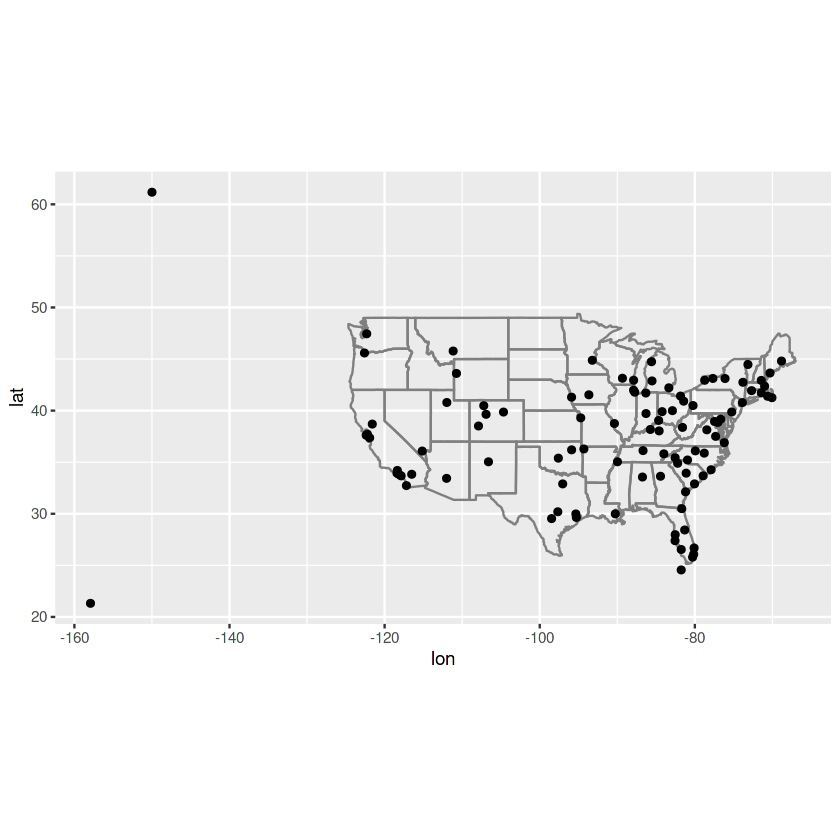

In [ ]:
airports |>
  semi_join(flights, join_by(faa == dest)) |>
  ggplot(aes(x = lon, y = lat)) +
    borders("state") +
    geom_point() +
    coord_quickmap()